In [70]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten

Num GPUs Available:  1


In [43]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [44]:
photozdata = pd.read_csv('/mnt/data/HSC/HSC_v6/HSC_v6.csv')

In [45]:
# filter & duplicate drop from bayesian_nn
filt = (photozdata['specz_redshift'] < 1)\
& (photozdata['specz_redshift'] > 0.01)\
& (photozdata['specz_redshift_err'] > 0) \
& (photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift_err"]<0.005*(1+photozdata["specz_redshift"]))\
&(photozdata['g_cmodel_mag'] >0)\
&(photozdata['r_cmodel_mag'] >0)\
&(photozdata['i_cmodel_mag'] >0)\
&(photozdata['z_cmodel_mag'] >0)\
&(photozdata['y_cmodel_mag'] >0)\
&(photozdata['g_cmodel_mag'] < 50)\
&(photozdata['r_cmodel_mag'] < 50)\
&(photozdata['i_cmodel_mag'] < 50)\
&(photozdata['z_cmodel_mag'] < 50)\
&(photozdata['y_cmodel_mag'] < 50)\
&(photozdata['specz_flag_homogeneous'] == True)
photozdata.drop_duplicates(subset=['object_id'])
photozdata_subset = np.asarray(photozdata[filt])

In [46]:
photozdata.columns

Index(['object_id', 'specz_redshift_err', 'specz_redshift', 'specz_mag_i',
       'specz_name', 'specz_ra', 'specz_dec', 'specz_flag_homogeneous', 'ra',
       'dec', 'coord', 'skymap_id', 'g_cmodel_mag', 'r_cmodel_mag',
       'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag', 'g_cmodel_magsigma',
       'r_cmodel_magsigma', 'i_cmodel_magsigma', 'z_cmodel_magsigma',
       'y_cmodel_magsigma'],
      dtype='object')

In [47]:
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
random.shuffle(photozdata_subset)
# shuffle the data

In [48]:
n = len(photozdata_subset)
print(n)

251573


In [49]:
count = 6 # number of networks, including the BNN

In [50]:
# split data into 6/7 bins of training sets of 40000 and 1 bin of testing set of 6401
X = []
y = []

pre = int(0)
per = int((n-n%10000)/count - 1)

for i in range(0,count):
    X.append(np.asarray(photozdata_subset[pre:per + 1][:,[12,13,14,15,16]]).astype('float32'))
    y.append(np.asarray(photozdata_subset[pre:per + 1][:,2]).astype('float32'))
    pre = per + 1
    per = per + int((n-n%10000)/count)

X_test = np.asarray(photozdata_subset[pre : n][:,[12,13,14,15,16]]).astype('float32')
y_test = np.asarray(photozdata_subset[pre : n][:,2]).astype('float32')

In [51]:
models = []

for i in range(1,count):
    input_ = tf.keras.layers.Input(shape=X[0].shape[1:])
    hidden1 = tf.keras.layers.Dense(200, activation="relu")(input_)
    hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
    hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
    hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
    # hidden5 = tf.keras.layers.Dense(200, activation="relu")(hidden4)
    # hidden6 = tf.keras.layers.Dense(200, activation="relu")(hidden5)
    concat = tf.keras.layers.Concatenate()([input_, hidden4])
    output = tf.keras.layers.Dense(1)(concat)
    model = tf.keras.Model(inputs=[input_], outputs=[output])
    model.compile(optimizer='Adam', loss="mse",metrics=[tf.keras.metrics.MeanAbsoluteError()])
    models.append(model)

In [52]:
for i in range(0,count - 1):
    models[i].fit(X[i],y[i],epochs=50,shuffle = True,verbose=1)

Epoch 1/50
1303/1303 [==============================] - 3s 2ms/step - loss: 0.0301 - mean_absolute_error: 0.1185
Epoch 2/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0754
Epoch 3/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0679
Epoch 4/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0642
Epoch 5/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0632
Epoch 6/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0709
Epoch 7/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0096 - mean_absolute_error: 0.0702
Epoch 8/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0693
Epoch 9/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0094 - mean_absolu

1303/1303 [==============================] - 2s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0578
Epoch 24/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0571
Epoch 25/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0566
Epoch 26/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0566
Epoch 27/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0551
Epoch 28/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0591
Epoch 29/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0594
Epoch 30/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0078 - mean_absolute_error: 0.0579
Epoch 31/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0078 - mean_absolute_

1303/1303 [==============================] - 2s 2ms/step - loss: 0.0064 - mean_absolute_error: 0.0508
Epoch 46/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0528
Epoch 47/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0517
Epoch 48/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0069 - mean_absolute_error: 0.0533
Epoch 49/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0065 - mean_absolute_error: 0.0511
Epoch 50/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0525
Epoch 1/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0941 - mean_absolute_error: 0.1480
Epoch 2/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0162 - mean_absolute_error: 0.0921
Epoch 3/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0125 - mean_absolute_err

1303/1303 [==============================] - 2s 2ms/step - loss: 0.0084 - mean_absolute_error: 0.0618
Epoch 18/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0600
Epoch 19/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0087 - mean_absolute_error: 0.0623
Epoch 20/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0616
Epoch 21/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0600
Epoch 22/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0083 - mean_absolute_error: 0.0602
Epoch 23/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0613
Epoch 24/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0622
Epoch 25/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0092 - mean_absolute_

In [53]:
# notice that the array is transposed, so we can directly compared the predictions on the same given x
y_predict = []

for i in range(0,count - 1):
    y_predict_single = []
    for j in range(0,len(X_test)):
        predicted = models[i].predict(np.array([X_test[j]]))
        y_predict_single.append(float(predicted))
    y_predict.append(y_predict_single)
    
y_predict = np.transpose(y_predict)

In [54]:
mean_array = []
std_array = []
for i in range(0,len(X_test)):
    mean = np.mean(y_predict[i])
    std = np.std(y_predict[i])
    mean_array.append(mean)
    std_array.append(std)

In [55]:
from scipy.stats import gaussian_kde
xy = np.vstack([y_test,mean_array])
z = gaussian_kde(xy)(xy)

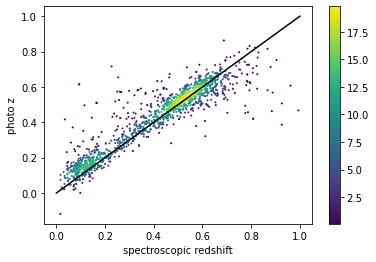

In [56]:
import matplotlib.cm as cm
import matplotlib
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_test, mean_array, c = z, s = 1, edgecolor = None)
plt.colorbar(scatter_plot)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 1], [0, 1],color = 'black')

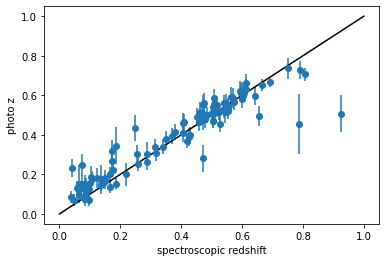

In [72]:
# sampled display
sample_count = 100
fig, ax = plt.subplots()
error_plot = ax.errorbar(y_test[0:sample_count], mean_array[0:sample_count], yerr = std_array[0:sample_count], fmt="o")
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([0, 1], [0, 1],color = 'black')

In [58]:
overlap = 0
overlap_array = []
for i in range(0,len(X_test)):
    if np.abs(y_test[i]-mean_array[i])<=std_array[i]:
        overlap += 1
        overlap_array.append(1)
    else:
        overlap_array.append(0)
print(overlap/len(X_test))

0.6100190234622701


In [59]:
combined_array = np.transpose(np.vstack((y_test,mean_array,std_array,overlap_array)))

In [60]:
sorted_combined_array = sorted(combined_array, key=lambda x: x[0])

In [65]:
bins = 10
splitted_sorted_combined_array = np.array_split(sorted_combined_array,bins)
coverage = []
for i in range(0,bins):
    count = 0
    for j in range(0,len(splitted_sorted_combined_array[i])):
        if splitted_sorted_combined_array[i][j][3] == 1:
            count += 1
    coverage.append(count/len(splitted_sorted_combined_array[i])/0.6827)
x_array = np.arange(0,1,1/bins)

(0.0, 1.5)

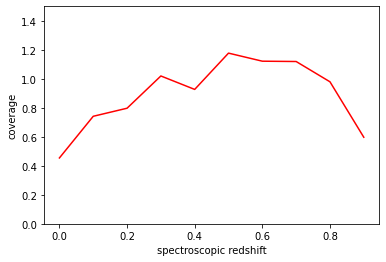

In [74]:
plt.plot(x_array, coverage, c = 'red')
plt.xlabel('spectroscopic redshift')
plt.ylabel('coverage')
plt.ylim([0,1.5]) # 1.5 indicates full coverage